In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

plt.style.use('dark_background')

from utils import modeling_utils as mu
from utils.plotting_utils import *

In [2]:
df = pd.read_csv('../data/german_credit_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = [x.lower().replace(' ', '_') for x in df.columns]
df['target'] = (df.risk == 'bad').astype(int)
df.sample(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,target
47,23,female,0,rent,quite rich,little,1352,6,car,good,0
254,24,male,2,own,NaN,moderate,2030,9,furniture/equipment,good,0
85,29,female,3,own,little,NaN,1412,12,business,good,0


In [3]:
test_set_results = pd.read_csv('../data/test_set_results.csv')

In [4]:
y_test = test_set_results.y_test
y_pred_proba = test_set_results.y_pred_proba

## scenario 1 
 - Loss from acquiring a bad customer equals the gain from acquiring a good one

In [5]:
## scenario 1
bad_client_incidence = 0.3
bad_customer_cost = 1

m = metrics_by_threshold_table = mu.get_metrics_by_threshold_table(y_test, y_pred_proba, bad_customer_cost)

In [6]:
m

,thres,precision,recall/sensitivity,specificity,lost_good_clients,avoided_bad_clients,loss,gain,expected_return,bottom_line,color
0,0.0,30.00,100.00,0.00,140,60,140,60,-80,0,silver
1,0.1,32.96,98.33,14.29,120,59,120,59,-61,19,silver
2,0.2,40.00,90.00,42.14,81,54,81,54,-27,53,silver
3,0.3,46.24,71.67,64.29,50,43,50,43,-7,73,silver
4,0.4,53.03,58.33,77.86,31,35,31,35,4,84,silver
5,0.5,62.16,38.33,90.00,14,23,14,23,9,89,silver
6,0.6,82.35,23.33,97.86,3,14,3,14,11,91,gold
7,0.7,100.00,10.00,100.00,0,6,0,6,6,86,silver
8,0.8,NaN,0.00,100.00,0,0,0,0,0,80,silver


#### Model return vs threhsold choice

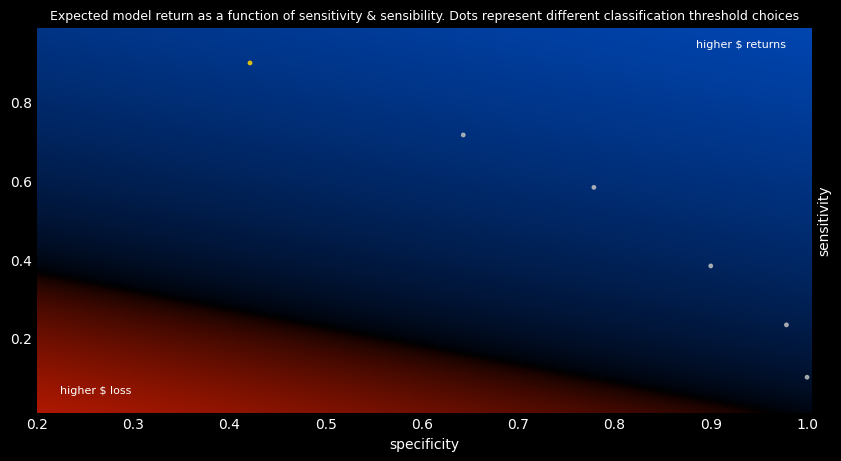

In [18]:
plot_specificity_sensitivity(bad_client_incidence = bad_client_incidence, bad_client_cost = bad_customer_cost,
         specificity_range = (0.2, 1.005), sensitivity_range = (0.01, .99), 
         highlighted_points = [
                m['specificity']/100, m['recall/sensitivity']/100,
                m['thres'].tolist(), m['color'].tolist()], 
                clip = 100)

plt.savefig('../figures/returns_versus_sensitivity_and_sensibility.png', 
              bbox_inches=None ,pad_inches=0,format='png', dpi=300, transparent = False)

The plot above shows the expected returns of models given its specificities and sensitivities. Red color means positive returns, and red colors means money loss. 

The dots represents our model's performance for different classification thresholds. we can see that even though there's a threshold range for which the model incurs loss, the blue range is wide.  

This is a relevant observation because in a production system the threshold performances can vary over time as training data and model parameter choices change. 


#### Model return vs bad client incidence and bad client loss variations
Below we can see how the model expected return is affected by changes in bad_client_incidence and bad_client_cost. This is relevant because the incidence of bad clients can vary over time, and that could potentially render the model useless or harmful. 

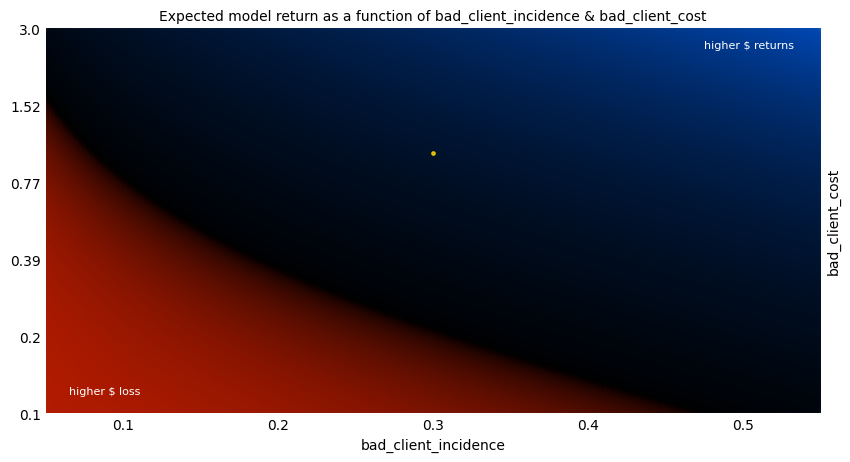

In [8]:
sensitivity, specificity, threshold = m[m.color == 'gold'][['recall/sensitivity', 'specificity', 'thres']].values[0]/100

plot_default_and_loss(specificity = specificity, sensitivity = sensitivity,
     bad_client_incidence_range = (0.05, 0.55),
        bad_client_cost_range = (0.1, 3),
        highlighted_points=(bad_client_incidence, bad_customer_cost))

We can see here that the model - on the best threshold choice above -  could start causing harm if the bad_client_incidence fell ~sixfold, to about 5% of customers, or if the cost of acquiring a bad customer fell drastically to ~20% of the gain of a good customer

## scenario 2

In [9]:
## scenario 1
bad_client_incidence = 0.3
bad_customer_cost = 5

m = metrics_by_threshold_table = mu.get_metrics_by_threshold_table(y_test, y_pred_proba, bad_customer_cost)

In [10]:
m

,thres,precision,recall/sensitivity,specificity,lost_good_clients,avoided_bad_clients,loss,gain,expected_return,bottom_line,color
0,0.0,30.00,100.00,0.00,140,60,140,300,160,0,silver
1,0.1,32.96,98.33,14.29,120,59,120,295,175,15,silver
2,0.2,40.00,90.00,42.14,81,54,81,270,189,29,gold
3,0.3,46.24,71.67,64.29,50,43,50,215,165,5,silver
4,0.4,53.03,58.33,77.86,31,35,31,175,144,-16,silver
5,0.5,62.16,38.33,90.00,14,23,14,115,101,-59,silver
6,0.6,82.35,23.33,97.86,3,14,3,70,67,-93,silver
7,0.7,100.00,10.00,100.00,0,6,0,30,30,-130,silver
8,0.8,NaN,0.00,100.00,0,0,0,0,0,-160,silver


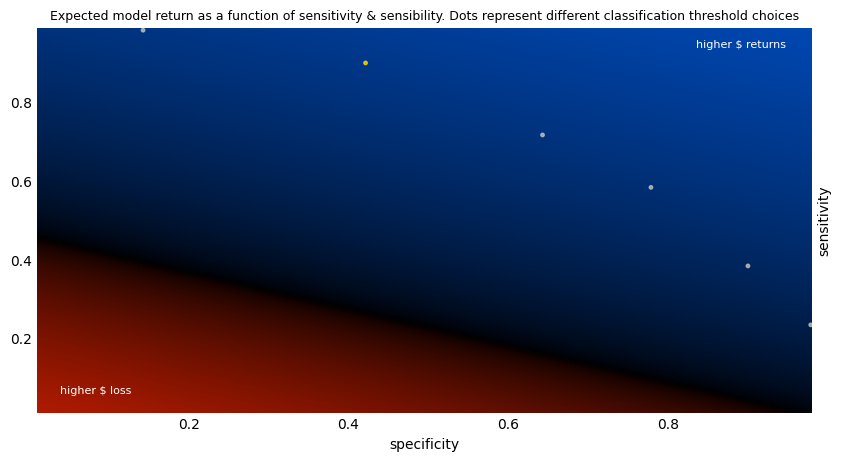

In [11]:
plot_specificity_sensitivity(bad_client_incidence = bad_client_incidence, bad_client_cost = bad_customer_cost,
         specificity_range = (0.01, .98), sensitivity_range = (0.01, .99), 
         highlighted_points = [
                m['specificity']/100, m['recall/sensitivity']/100,
                m['thres'].tolist(), m['color'].tolist()])

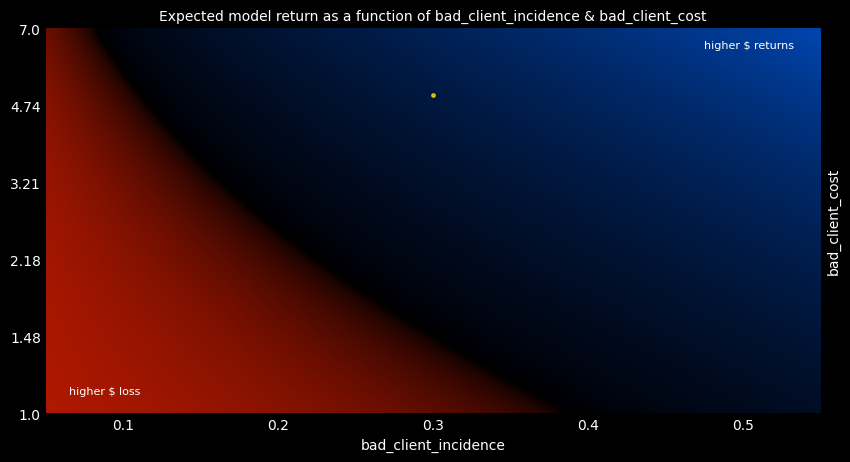

In [17]:
sensitivity, specificity, threshold = m[m.color == 'gold'][['recall/sensitivity', 'specificity', 'thres']].values[0]/100

plot_default_and_loss(specificity = specificity, sensitivity = sensitivity,
     bad_client_incidence_range = (0.05, 0.55),
        bad_client_cost_range = (1, 7),
        highlighted_points=(bad_client_incidence, bad_customer_cost))